# Time Series Data: Stock Price Prediction

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>"))

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
inp0 = pd.read_csv('../Datasets/AAPL.csv')
inp0.head()

,Date,Close,Open,High,Low,Volume
0,1/17/2020,138.31,136.54,138.330,136.16,5623336
1,1/16/2020,137.98,137.32,138.190,137.01,4320911
2,1/15/2020,136.62,136.00,138.055,135.71,4045952
3,1/14/2020,135.82,136.28,137.139,135.55,3683458
4,1/13/2020,136.60,135.48,136.640,135.07,3531572


In [4]:
inp0.tail()

,Date,Close,Open,High,Low,Volume
2509,1/29/2010,122.39,124.32,125.000,121.90,11571890
2510,1/28/2010,123.75,127.03,127.040,123.05,9616132
2511,1/27/2010,126.33,125.82,126.960,125.04,8719147
2512,1/26/2010,125.75,125.92,127.750,125.41,7135190
2513,1/25/2010,126.12,126.33,126.895,125.71,5738455


# Exercise 5.01: Visualizing our Time Series Data

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
inp0 = pd.read_csv('../Datasets/AAPL.csv')

Plot the column 'Close' as a line plot to see the pattern using the plot method of the dataframe

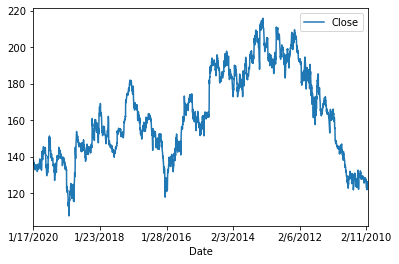

In [5]:
inp0.plot("Date", "Close")
plt.show()

We see that the index is in reverse order - latest date beginning at 0. We’ll reverse the data for convenience of plotting and handling.

In [6]:
inp0 = inp0.sort_index(ascending=False)

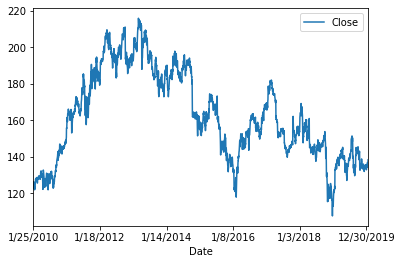

In [7]:
inp0.plot("Date", "Close")
plt.show()

Extract the values for ‘Close’ from the dataframe as a numpy array.

In [8]:
ts_data = inp0.Close.values.reshape(-1,1)

Plot the values as a line plot using matplotlib

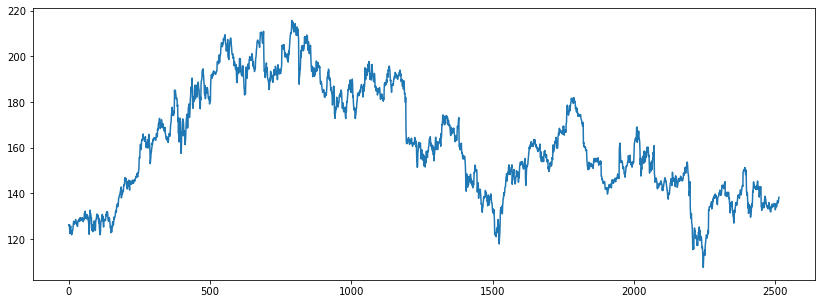

In [10]:
plt.figure(figsize=[14,5])
plt.plot(ts_data)
plt.show()

# Exercise 5.02: Implement the Forward Pass of a Simple RNN using Tensorflow

Import Tensorflow and numpy

In [11]:
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

Define constants ‘num_inputs’ and ‘num_neurons’ holding the number of inputs (2) and the number of neurons in the hidden layer (3) respectively.

In [12]:
num_inputs = 2
num_neurons = 3

Define the variables for the weight matrices. We need two of them – one for the feedforward weights, the other for the recurrent weights. Initialize them randomly.

In [13]:
Wf = tf.Variable(tf.random.normal(shape=[num_inputs, num_neurons]))
Wr = tf.Variable(tf.random.normal(shape=[num_neurons, num_neurons]))

Add the bias variable, as many values as the number of neurons in the hidden layer

In [14]:
b = tf.Variable(tf.zeros([1,num_neurons]))

Create the data – 3 examples for xt0 (two inputs, 3 examples) as [[0,1],[2,3],[4,5]] and xt1 as [[100,101],[102,103],[104,105]]

In [15]:
xt0_batch = np.array([[0,1],  [2,3], [4,5]]).astype(np.float32)
xt1_batch = np.array([[100, 101], [102, 103], [104, 105]]).astype(np.float32)

Define function to apply forward pass for given data xt0, xt1

In [16]:
def forward_pass(xt0, xt1):
    yt0 = tf.tanh(tf.matmul(xt0, Wf) + b)
    yt1 = tf.tanh(tf.matmul(yt0, Wr) + tf.matmul(xt1, Wf) + b)
    return yt0, yt1

Perform the forward pass by calling the function with the created data

In [17]:
yt0_output, yt1_output = forward_pass(xt0_batch, xt1_batch)

Print the output values yt0 and yt1

In [18]:
tf.print(yt0_output)

[[-0.776318431 -0.844548464 0.438419849]
 [-0.0857750699 -0.993522227 0.516408086]
 [0.6983459 -0.999749422 0.586677969]]


In [19]:
tf.print(yt1_output)

[[1 -1 0.99999851]
 [1 -1 0.999998331]
 [1 -1 0.999997377]]


### Preparing the Data for Stock Price Prediction

In [20]:
train_recs = int(len(ts_data) * 0.75)

In [21]:
train_data = ts_data[:train_recs]
test_data = ts_data[train_recs:]

In [22]:
len(train_data), len(test_data)

(1885, 629)

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [25]:
def get_lookback(inp, look_back):       
    y = pd.DataFrame(inp)
    dataX = [y.shift(i) for i in range(1, look_back+1)]
    dataX = pd.concat(dataX, axis=1)
    dataX.fillna(0, inplace = True)
    return dataX.values, y.values

In [26]:
look_back = 10

In [27]:
trainX, trainY = get_lookback(train_scaled, look_back=look_back)
testX, testY = get_lookback(test_scaled, look_back= look_back)

In [28]:
trainX.shape, testX.shape

((1885, 10), (629, 10))

# Exercise 5.03: Building our first plain RNN model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Activation, Dropout, Dense, Reshape

In [31]:
model = Sequential()
model.add(Reshape((look_back,1), input_shape = (look_back,)))
model.add(SimpleRNN(32, input_shape=(look_back, 1)))
model.add(Dense(1))
model.add(Activation('linear'))

In [32]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 10, 1)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1088      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


### Model Training and Performance Evaluation

In [34]:
model.fit(trainX, trainY, epochs=3, batch_size=1, verbose=2, validation_split=0.1)

Train on 1696 samples, validate on 189 samples
Epoch 1/3
1696/1696 - 5s - loss: 0.0036 - val_loss: 0.0016
Epoch 2/3
1696/1696 - 4s - loss: 0.0012 - val_loss: 4.9603e-04
Epoch 3/3
1696/1696 - 4s - loss: 0.0010 - val_loss: 3.6961e-04


In [35]:
import math

In [36]:
def get_model_perf(model_obj):

    score_train = model_obj.evaluate(trainX, trainY, verbose=0)
    print('Train RMSE: %.2f RMSE' % (math.sqrt(score_train)))

    score_test = model_obj.evaluate(testX, testY, verbose=0)
    print('Test RMSE: %.2f RMSE' % (math.sqrt(score_test)))

In [37]:
get_model_perf(model)

Train RMSE: 0.02 RMSE
Test RMSE: 0.03 RMSE


In [38]:
def plot_pred(model_obj):
    testPredict = scaler.inverse_transform(model_obj.predict(testX))
    
    pred_test_plot = ts_data.copy()
    pred_test_plot[:train_recs+look_back,:] = np.nan
    pred_test_plot[train_recs+look_back:,:] = testPredict[look_back:]
    
    plt.plot(ts_data)
    plt.plot(pred_test_plot, "--")

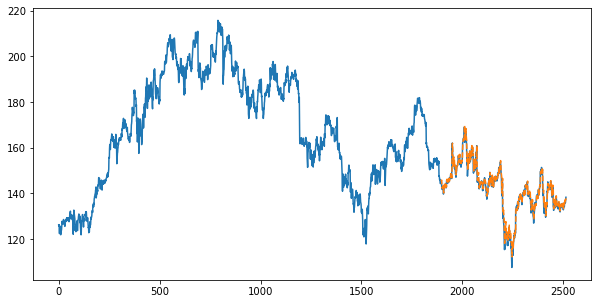

In [39]:
%matplotlib inline
plt.figure(figsize=[10,5])
plot_pred(model)

<IPython.core.display.Javascript object>


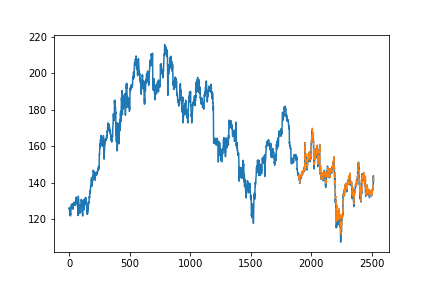

In [78]:
%matplotlib notebook
plot_pred(model)

# Exercise 5.04: Build 1D convolution-based model

In [41]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

In [42]:
model_conv = Sequential()
model_conv.add(Reshape((look_back,1), input_shape = (look_back,)))
model_conv.add(Conv1D(5, 5, activation='relu'))
model_conv.add(MaxPooling1D(5))
model_conv.add(Flatten())
model_conv.add(Dense(1))
model_conv.add(Activation('linear'))

In [43]:
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 5)              30        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 5)              0         
_________________________________________________________________
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 36
Trainable params: 36
Non-trainable params: 0
__________________________________________________________

In [44]:
model_conv.compile(loss='mean_squared_error', optimizer='adam')

In [45]:
model_conv.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2, validation_split=0.1)

Train on 1696 samples, validate on 189 samples
Epoch 1/5
1696/1696 - 2s - loss: 0.0351 - val_loss: 0.0013
Epoch 2/5
1696/1696 - 2s - loss: 0.0022 - val_loss: 0.0020
Epoch 3/5
1696/1696 - 2s - loss: 0.0021 - val_loss: 0.0012
Epoch 4/5
1696/1696 - 2s - loss: 0.0021 - val_loss: 0.0014
Epoch 5/5
1696/1696 - 2s - loss: 0.0020 - val_loss: 0.0011


In [46]:
get_model_perf(model_conv)

Train RMSE: 0.04 RMSE
Test RMSE: 0.05 RMSE


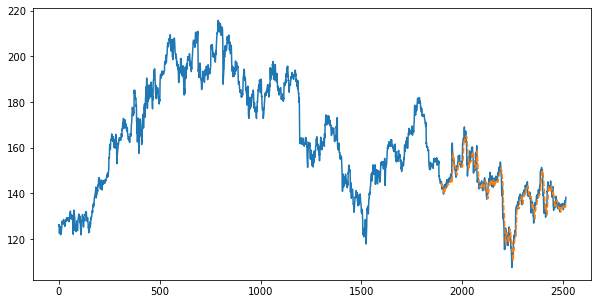

In [47]:
%matplotlib inline
plt.figure(figsize=[10,5])
plot_pred(model_conv)

<IPython.core.display.Javascript object>


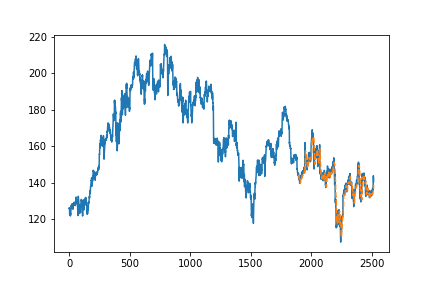

In [79]:
%matplotlib notebook
plot_pred(model_conv)

# Exercise 5.05: Build a hybrid (1D conv + RNN) model

In [49]:
model_comb = Sequential()
model_comb.add(Reshape((look_back,1), input_shape = (look_back,)))
model_comb.add(Conv1D(5, 3, activation='relu'))
model_comb.add(SimpleRNN(32))
model_comb.add(Dense(1))
model_comb.add(Activation('linear'))

In [50]:
model_comb.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 5)              20        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                1216      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,269
Trainable params: 1,269
Non-trainable params: 0
_________________________________________________________________


In [51]:
model_comb.compile(loss='mean_squared_error', optimizer='adam')

In [52]:
model_comb.fit(trainX, trainY, epochs=3, batch_size=1, verbose=2, validation_split=0.1)

Train on 1696 samples, validate on 189 samples
Epoch 1/3
1696/1696 - 4s - loss: 0.0027 - val_loss: 9.8190e-04
Epoch 2/3
1696/1696 - 4s - loss: 0.0012 - val_loss: 5.8988e-04
Epoch 3/3
1696/1696 - 4s - loss: 0.0012 - val_loss: 5.0359e-04


In [53]:
get_model_perf(model_comb)

Train RMSE: 0.03 RMSE
Test RMSE: 0.03 RMSE


<IPython.core.display.Javascript object>


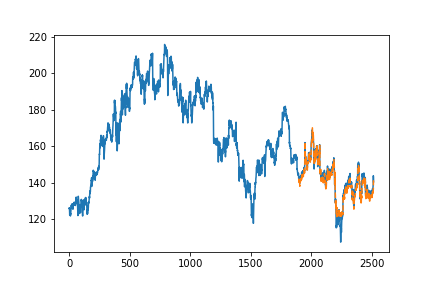

In [80]:
%matplotlib notebook
plot_pred(model_comb)

## Activity 5.01: IBM stock price prediction using RNNs + 1D convnet

1. Load the csv file, reverse the index and plot the time series (‘Close’ column) for visual inspection

In [55]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

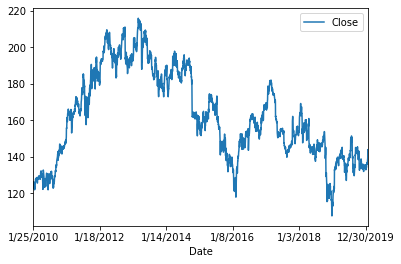

In [56]:
inp0 = pd.read_csv("IBM.csv")
inp0 = inp0.sort_index(ascending=False)
inp0.plot("Date", "Close")
plt.show()

In [57]:
ts_data = inp0.Close.values.reshape(-1,1)

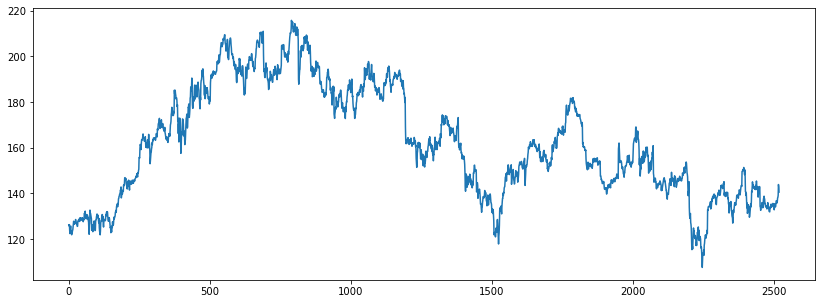

In [58]:
%matplotlib inline
plt.figure(figsize=[14,5])
plt.plot(ts_data)
plt.show()

2. Assign the final 25% data as test data, first 75% as train

In [59]:
train_recs = int(len(ts_data) * 0.75)

In [60]:
train_data = ts_data[:train_recs]
test_data = ts_data[train_recs:]

In [61]:
len(train_data), len(test_data)

(1888, 630)

3. Using MinMaxScaler from sklearn, scale the train and test data

In [62]:
from sklearn.preprocessing import MinMaxScaler

In [63]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

4. Using the get_lookback function defined in the chapter, get lookback data for train and the test data using a lookback period of 10.

In [64]:
look_back = 10

In [65]:
trainX, trainY = get_lookback(train_scaled, look_back=look_back)
testX, testY = get_lookback(test_scaled, look_back= look_back)

In [66]:
trainX.shape, testX.shape

((1888, 10), (630, 10))

5. From Keras, import all necessary layers for employing plain RNNs (SimpleRNN, Activation, Dropout, Dense, Reshape) and 1D convolutions (Conv1D). Also import mean_squared_error metric from sklearn

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Activation, Dropout, Dense, Reshape, Conv1D
from sklearn.metrics import mean_squared_error

6. Build a model with a 1D convolution layer (5 filters of size 3) and an RNN layer with 32 neurons. Add 25% dropout after the RNN layer. Print the model’s summary.

In [68]:
model_comb = Sequential()
model_comb.add(Reshape((look_back,1), input_shape = (look_back,)))
model_comb.add(Conv1D(5, 3, activation='relu'))
model_comb.add(SimpleRNN(32))
model_comb.add(Dropout(0.25))
model_comb.add(Dense(1))
model_comb.add(Activation('linear'))

In [69]:
model_comb.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 5)              20        
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                1216      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 1,269
Trainable params: 1,269
Non-trainable params: 0
____________________________________________________

7. Compile the model with “mean_squared_error” loss and ‘adam’ optimizer. Fit on the train data in 5 epochs, validation split of 10%, batch size of 1.

In [70]:
model_comb.compile(loss='mean_squared_error', optimizer='adam')

In [71]:
model_comb.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2, validation_split=0.1)

Train on 1699 samples, validate on 189 samples
Epoch 1/5
1699/1699 - 4s - loss: 0.0106 - val_loss: 0.0022
Epoch 2/5
1699/1699 - 4s - loss: 0.0046 - val_loss: 9.4285e-04
Epoch 3/5
1699/1699 - 4s - loss: 0.0033 - val_loss: 4.1030e-04
Epoch 4/5
1699/1699 - 4s - loss: 0.0028 - val_loss: 6.9368e-04
Epoch 5/5
1699/1699 - 4s - loss: 0.0020 - val_loss: 4.7287e-04


8. Using the get_model_perf method, print the RMSE from the model.

In [72]:
get_model_perf(model_comb)

Train RMSE: 0.03 RMSE
Test RMSE: 0.03 RMSE


9. Plot the predictions - the entire view, as well as zoomed in view

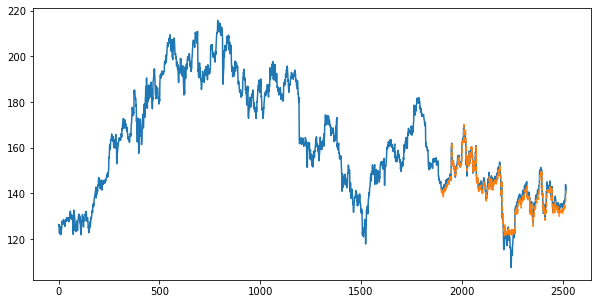

In [73]:
%matplotlib inline
plt.figure(figsize=[10,5])
plot_pred(model_comb)

<IPython.core.display.Javascript object>


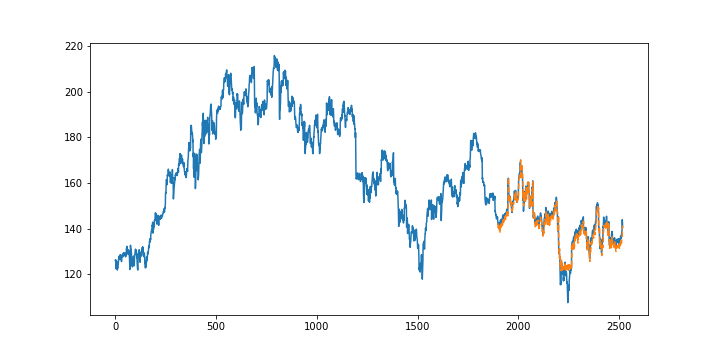

In [81]:
%matplotlib notebook
plt.figure(figsize=[10,5])
plot_pred(model_comb)